In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import joblib
from tqdm import tqdm
import pandas as pd
import argparse
import os

In [2]:
from main import weighted_l2, decode, PSNR, plot_data, load_ecg, load_train_ecg, load_test_ecg, create_pulse
max_signal_length = 100 # used in load_train_ecg and load_test_ecg to keep an integer multiple of patch_size number of samples  

In [3]:
# default values
# cnt is the number of plots to be saved for each (n_components, n_train, patch_size) tuple 
n_train, n_test, n_components, cnt = 10000, 1000, 5, 5
n_init, d, to_train, use_mat = 5, 30, True, False # d is the patch size

# for pulse
num_peaks = d//10
peak_width = 10

folder_name = 'results/n_components=%d,n_train=%d,patch_size=%d/' % (n_components, n_train, d)

In [4]:
def generate_covariance_matrices(n_components, d):
    ans = []
    for i in range(n_components):
        k = (d//3) * 2 # something lesser than d
        W = np.random.rand(d,k)
        S = (W @ W.transpose()) + np.diag(np.random.rand(1,d) * 0.01)
        S = np.diag(1/np.sqrt(np.diag(S))) @ S @ np.diag(1/np.sqrt(np.diag(S)))
        ans.append(S)
    return np.array(ans)

In [5]:
gen_model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
# suppose we are training on n dimensional data

gen_model.weights_ = np.random.rand(n_components,)
gen_model.weights_ /= np.sum(gen_model.weights_)

gen_model.means_ = np.random.rand(n_components, d) * 100
gen_model.covariances_ = generate_covariance_matrices(n_components, d)

[0.03321955 0.07876231 0.22801407 0.32613846 0.33386562]
(5,)
(5, 30)
(5, 30, 30)


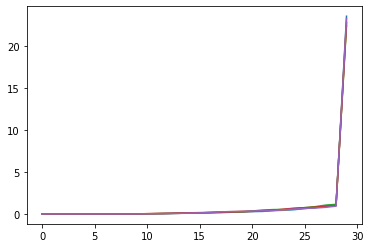

In [6]:
print(gen_model.weights_) # check if no single component gets majority of the weight 
print(gen_model.weights_.shape)
print(gen_model.means_.shape)
print(gen_model.covariances_.shape)

# sanity check of covariance matrix
for i in range(n_components):
    # asserting checks if matrix is positive definite
    assert(np.linalg.det(gen_model.covariances_[i,:,:]) + 1e-10 > 0)
    plt.plot(np.linalg.eigvalsh(gen_model.covariances_[i,:,:]))
    
plt.show()

In [7]:
train_data,_ = gen_model.sample(n_train)
train_data.shape

(10000, 30)

In [8]:
# here one assumption is that we know the number of components, however this will have to be varied
model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
model.fit(train_data)

if os.path.isdir(folder_name):
    for f in os.listdir(folder_name):
        if not os.path.isdir(folder_name + f):
            os.remove(folder_name + f)
else:
    os.makedirs(folder_name)

# Save the model as a pickle in a file
joblib.dump(model, folder_name + 'model.pkl')

Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True


['results/n_components=5,n_train=10000,patch_size=30/model.pkl']

In [ ]:
test_data = gen_model.sample(n_test)
A_ = np.random.binomial(1, 0.5, size=(d, d))

ms = [d*(i+1)//10 for i in range(10)]
psnr, psnr_min, psnr_max, psnr_std = [], [], [], []
val_err, err_std = [], []

for m in tqdm(ms):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = m//5*4
    reconstruction = np.empty(test_data.shape)
    patch_err = []
    cnt1 = cnt
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            patch_err.append(100*np.mean(np.square(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d])))
        # cs example
        if cnt1 > 0:
            plt.plot(x, label='Original', color='C0')
            plt.plot(x_hat, label='Reconstructed', color='C1')
            plt.legend()
            plt.savefig(folder_name + 'cs_%d_%d.png' % (cnt1, mm))
            plt.close()
            cnt1 -= 1
        reconstruction[j] = x_hat
    val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    psnr.append(val)
    psnr_min.append(min_val)
    psnr_max.append(max_val)
    psnr_std.append(std_val)
    val_err.append(np.mean(patch_err))
    err_std.append(np.std(patch_err))

print(psnr)
# print(psnr_min)
# print(psnr_max)
print(psnr_std)
print(val_err)
print(err_std)
plot_data([x//5*4 for x in ms], psnr, path=folder_name + 'psnr.png')
plot_data([x//5*4 for x in ms], val_err, path=folder_name + 'val_err.png', ylabel='Validation error (1e-2)')